In [5]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from references.sparc import galaxy_list
from models.load import load_sparc

In [2]:
simulations = load_sparc(galaxy_list())

In [3]:
SPARC_MASS_RATIOS = {'gas': 1, 'disk': 0.5, 'bul': 0.7}

def velocity(R, F):
    return np.sign(F)*(np.abs(R*F)**0.5)

BOUNDS = [[29,0],[30,np.inf]]

def curve_fit(self):
    
    # combined masses dataframe
    cdf = self.dataframe(mass_ratios=SPARC_MASS_RATIOS, combined=True)
    
    def f(r, gamma, tau):
        al = 0.2
        ep = 0.5
        inulled = np.interp(r, cdf['rd'], cdf['x_abs']-cdf['x_vec'])
        iforce = np.interp(r, cdf['rd'], cdf['x_vec'])
        nforce = gamma*iforce/(1+((tau+ep*inulled))**al)
        return velocity(r, nforce)
    
    # rotmass reference dataframe
    rdf = self.profile.rotmass_df
    leng = int(len(rdf['R'])*0.9)
    bounds = BOUNDS
    popt, pcov = sp.optimize.curve_fit(f, rdf['R'][:leng], rdf['Vobs'][:leng], bounds=bounds)
    return popt, pcov, f

In [7]:
def sparc_dataframe(self):
    # use rotmass as the basis of the dataframe
    # (might be better to use mass model though)
    df = self.profile.rotmass_df.copy()
    
    # sparc table1 augments
    for k in ('D', 'e_D', 'Inc', 'e_Inc', 'Vflat', 'e_Vflat', 'Q', 'MHI', 'L[3.6]'):
        df[k] = self.profile.sparc_dict[k]
    
    # additional calculations
    df['u_Inc'] = self.profile.inc_used
    df['rel_R'] = df['R']/df['R'].max()
    
    # calculated newtonian velocities
    # ignore mass ratios for now
    # as rotmass is benchmarked to 1 M/L
    # will adjust for them later
    sim_df = self.dataframe(mass_ratios=False)
    
    for component, cdf in sim_df.groupby('component'):
        R = df['R']
        F = np.interp(R, cdf['rd'], cdf['x_vec'])
        df['W%s' % component] = velocity(R, F)
        
    # calculate gravity components Vbar & gbar
    # with mass ratios from sparc paper
    # https://arxiv.org/pdf/1606.09251.pdf eq.2
    mrs = SPARC_MASS_RATIOS
    for v in ('V', 'W'):
        key = '%sbar' % v
        df[key] = np.sum([mrs[c]*df["%s%s" % (v,c)]**2 for c in self.mass_labels],axis=0)**0.5
        df['%s_gbar' % v] = df[key]**2/df['R']
        df['log(%s_gbar)' % v] = np.log10(df['%s_gbar' % v])
    
    # observations
    df['gobs'] = df['Vobs']**2/df['R']
    df['log(gobs)'] = np.log10(df['gobs'])
    
    
    # override the W
    args, cov, func = curve_fit(self)
    df['log(W_gbar)'] = np.log10(func(df['R'], *args)**2/df['R'])
    return df
    

full_df = pd.concat([sparc_dataframe(sim) for sim in simulations.values()], ignore_index=True)
full_df
#sparc_dataframe(simulations['UGCA444'])

,R,Vobs,errV,Vgas,Vdisk,Vbul,SBgas,SBdisk,SBbul,ID,...,Wgas,Vbar,V_gbar,log(V_gbar),Wbar,W_gbar,log(W_gbar),gobs,log(gobs),Wbul
0,0.16,1.99,1.50,1.53,3.95,0.0,4.39,33.32,0.0,CamB,...,1.612072,3.184674,63.388438,1.802010,2.606095,42.448323,1.527565,24.750625,1.393586,NaN
1,0.41,4.84,1.50,3.59,9.97,0.0,3.81,26.13,0.0,CamB,...,3.886013,7.911293,152.655000,2.183711,8.858829,191.411827,2.181673,57.135610,1.756907,NaN
2,0.57,6.79,1.50,4.79,12.42,0.0,3.35,17.44,0.0,CamB,...,5.157708,10.003614,175.565439,2.244439,11.047874,214.132500,2.230387,80.884386,1.907865,NaN
3,0.73,8.87,1.50,5.79,14.50,0.0,2.79,13.62,0.0,CamB,...,6.249918,11.774935,189.930274,2.278594,12.277096,206.475462,2.214573,107.776575,2.032524,NaN
4,0.90,10.90,1.50,6.72,15.72,0.0,2.21,10.58,0.0,CamB,...,7.247654,12.989134,187.464000,2.272918,13.478144,201.844837,2.204723,132.011111,2.120610,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,2.33,36.10,5.47,13.59,5.43,0.0,0.63,0.21,0.0,UGCA444,...,13.865018,14.121988,85.592511,1.932436,14.363938,88.550527,2.613555,559.317597,2.747658,NaN
3323,2.40,37.20,5.39,13.27,5.47,0.0,0.00,0.19,0.0,UGCA444,...,13.513958,13.822205,79.605563,1.900943,14.015520,81.847834,2.579567,576.600000,2.760875,NaN
3324,2.48,37.60,7.10,12.69,5.54,0.0,0.00,0.17,0.0,UGCA444,...,13.059168,13.280885,71.121734,1.852002,13.564039,74.186761,2.537012,570.064516,2.755924,NaN
3325,2.55,35.60,4.73,12.30,5.48,0.0,0.00,0.00,0.0,UGCA444,...,12.609681,12.895937,65.217725,1.814366,13.117931,67.482401,2.495879,497.003922,2.696360,NaN


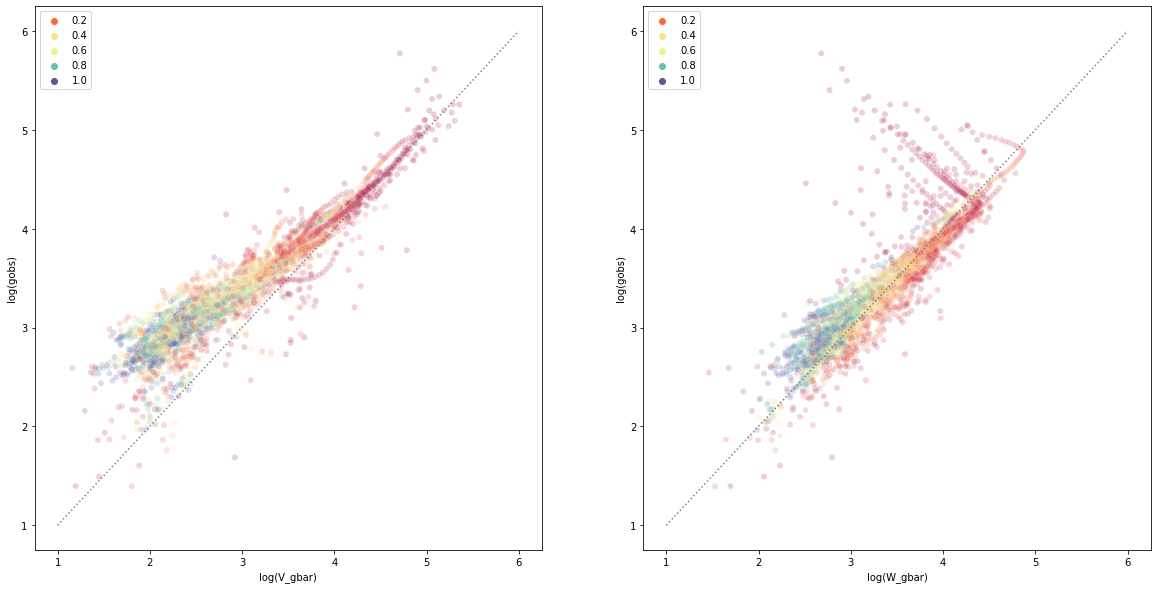

In [15]:
def plot_rar(df):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    for i, iden in enumerate(('V', 'W')):
        g = sns.scatterplot(data=df, x='log(%s_gbar)' % iden, y='log(gobs)', alpha=0.2, hue='rel_R', palette='Spectral', ax=axes[i])
        #g.set(xscale="log", yscale="log")
        
        line = [1,6]
        sns.lineplot(x=line, y=line, color='grey', ax=axes[i], linestyle='dotted')

plot_rar(full_df)

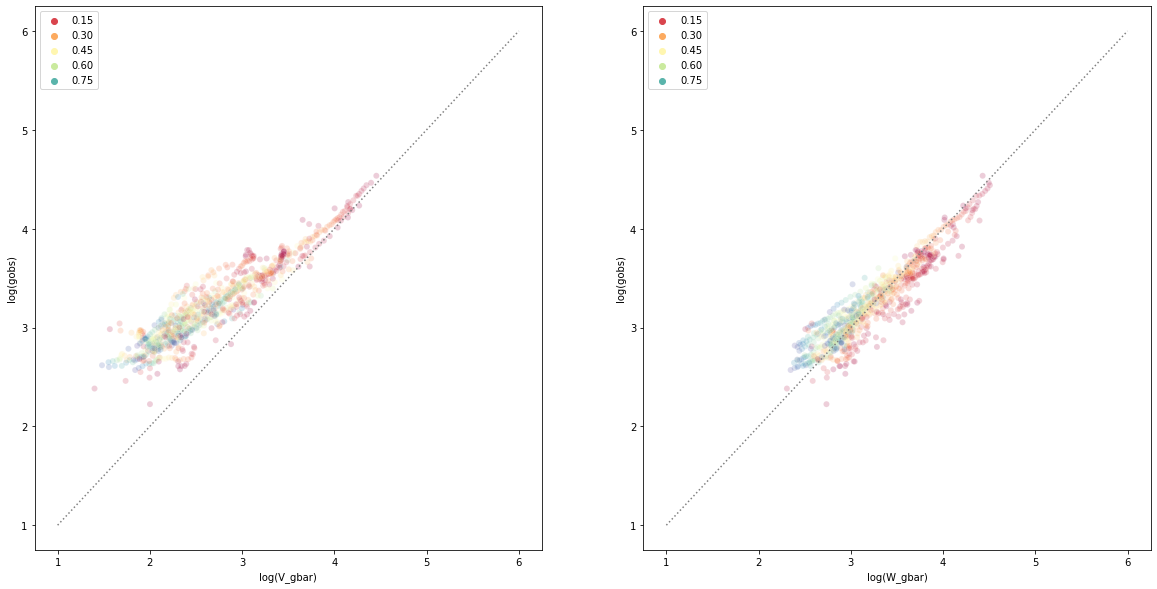

In [14]:
def filter_quality(df):
    return df.query("Q<2").query("Inc>30").query("Inc<80").query("Vbul==0.0").query("rel_R>0.05").query("rel_R<0.9")

filtered_df = filter_quality(full_df)
plot_rar(filtered_df)

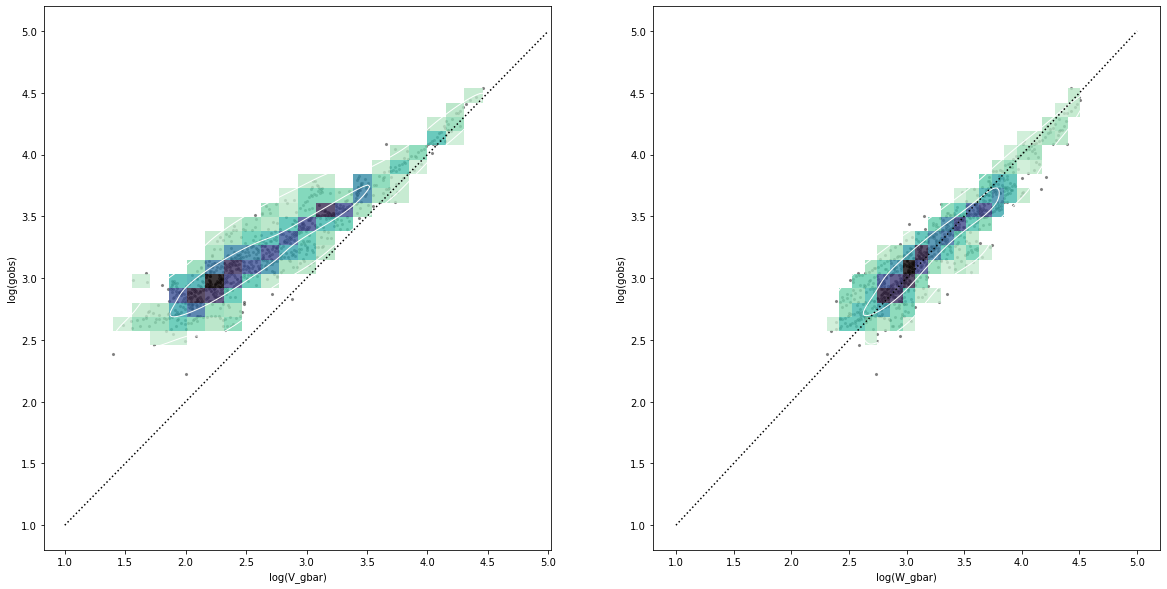

In [10]:
def plot_rar_denity(df, line=[1,5]):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    for i, iden in enumerate(('V', 'W')):
        x = 'log(%s_gbar)' % iden
        y = 'log(gobs)'
        sns.scatterplot(data=df, x=x, y=y, color='black', s=10, alpha=0.5, ax=axes[i])
        sns.histplot(data=df, x=x, y=y, bins=20, pthresh=.01, cmap="mako_r", ax=axes[i], alpha=0.8)
        sns.kdeplot(data=df, x=x, y=y, levels=3, color="w", linewidths=1, ax=axes[i])
        sns.lineplot(x=line, y=line, color='black', linestyle='dotted', ax=axes[i])

plot_rar_denity(filtered_df)

In [195]:
filtered_df['ID'].unique()

array(['DDO064', 'DDO161', 'ESO079-G014', 'ESO116-G012', 'F568-3',
       'F568-V1', 'F574-1', 'F583-1', 'F583-4', 'NGC0024', 'NGC1003',
       'NGC1090', 'NGC2403', 'NGC2903', 'NGC2998', 'NGC3109', 'NGC3198',
       'NGC3521', 'NGC3741', 'NGC3893', 'NGC3917', 'NGC3953', 'NGC3972',
       'NGC3992', 'NGC4088', 'NGC4100', 'NGC4559', 'NGC5055', 'NGC5371',
       'NGC5585', 'NGC6503', 'NGC7793', 'UGC00128', 'UGC00191',
       'UGC00731', 'UGC04325', 'UGC04499', 'UGC05005', 'UGC05414',
       'UGC05721', 'UGC05750', 'UGC06399', 'UGC06446', 'UGC06917',
       'UGC06930', 'UGC06983', 'UGC07323', 'UGC07399', 'UGC07524',
       'UGC07603', 'UGC08490', 'UGC10310', 'UGC11820', 'UGC12632',
       'UGC12732', 'UGCA442'], dtype=object)

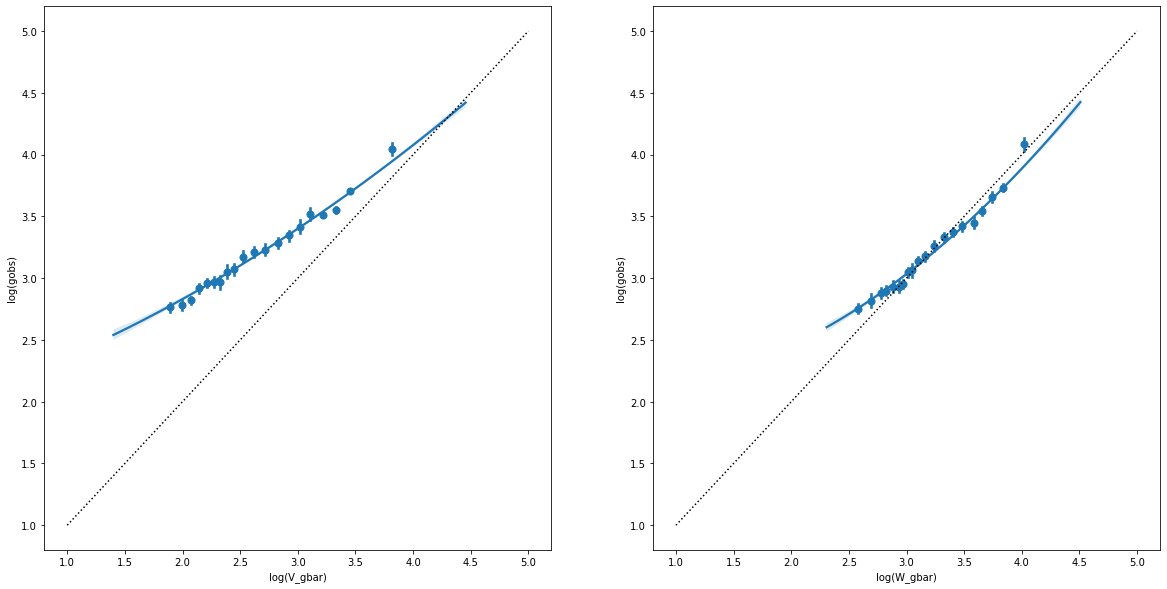

In [11]:
def plot_rar_regplot(df, line=[1,5]):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    for i, iden in enumerate(('V', 'W')):
        x = 'log(%s_gbar)' % iden
        y = 'log(gobs)'
        sns.regplot(data=df, x=x, y=y, order=2, ax=axes[i], x_bins=20)
        sns.lineplot(x=line, y=line, color='black', linestyle='dotted', ax=axes[i])

plot_rar_regplot(filtered_df)

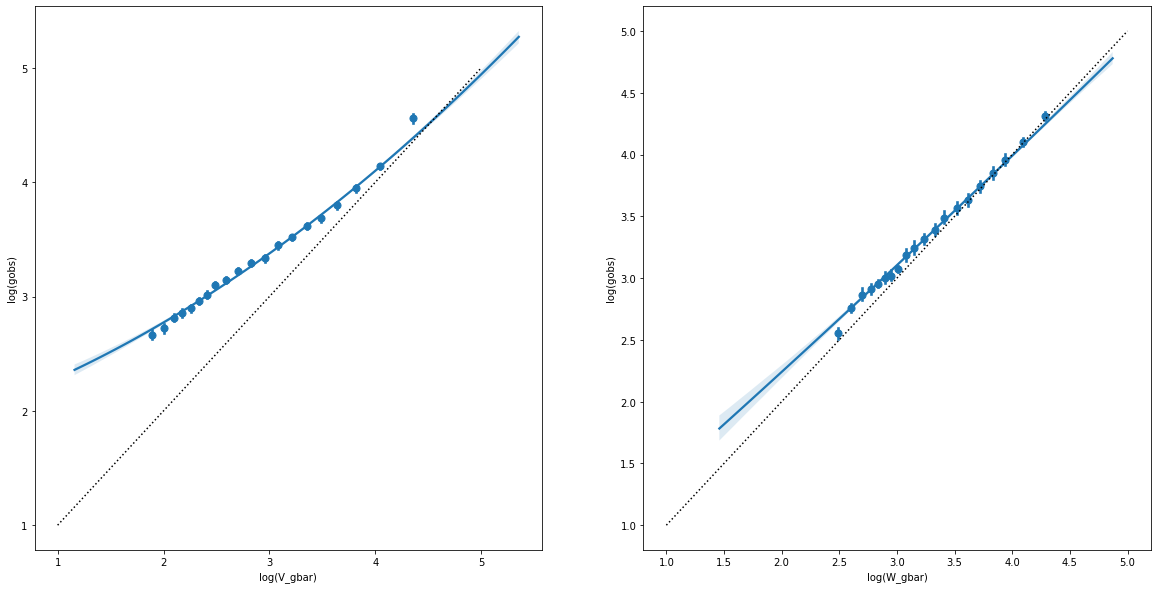

In [12]:
plot_rar_regplot(full_df)